# Dataset

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset

class BratsDataset(Dataset):
    def __init__(self, root_dir, patch_size=128):
        self.root_dir = root_dir
        self.samples = sorted(os.listdir(root_dir))
        self.patch_size = patch_size

    def __len__(self):
        return len(self.samples)

    def load_nii(self, path):
        return nib.load(path).get_fdata().astype(np.float32)

    def random_crop(self, img, mask, size):
        _, D, H, W = img.shape

        # đảm bảo D/H/W > size
        d = np.random.randint(0, max(1, D - size))
        h = np.random.randint(0, max(1, H - size))
        w = np.random.randint(0, max(1, W - size))

        return (
            img[:, d:d+size, h:h+size, w:w+size],
            mask[d:d+size, h:h+size, w:w+size]
        )

    def __getitem__(self, idx):
        case = self.samples[idx]
        folder = os.path.join(self.root_dir, case)

        # flair = self.load_nii(os.path.join(folder, case + "_flair.nii.gz"))
        t1 = self.load_nii(os.path.join(folder, case + "_t1.nii.gz"))
        # t1ce = self.load_nii(os.path.join(folder, case + "_t1ce.nii.gz"))
        # t2 = self.load_nii(os.path.join(folder, case + "_t2.nii.gz"))
        mask = self.load_nii(os.path.join(folder, case + "_seg.nii.gz"))
        mask[mask == 4] = 3  # convert ET label 4 → 3

        # stack modal
        image = np.stack([ t1], axis=0)
        # image = np.stack([flair, t1, t1ce, t2], axis=0)
        # normalize
        image = (image - image.mean()) / (image.std() + 1e-6)

        # crop patch 128³
        image, mask = self.random_crop(image, mask, self.patch_size)

        return (
            torch.tensor(image, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.long)
        )


# Unet3D

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet3D(nn.Module):
    def __init__(self, n_channels=4, n_classes=4):
        super().__init__()

        self.enc1 = DoubleConv(n_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose3d(512, 256, 2, stride=2)
        self.dec4 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv3d(32, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.dec4(u4)

        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.dec3(u3)

        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.dec2(u2)

        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.dec1(u1)

        return self.out_conv(c8)


# CNN3D

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3DModel(nn.Module):
    """
    Mô hình 3D CNN để phân loại voxel (segmentation) dựa trên ngữ cảnh cục bộ.
    Sử dụng kiến trúc Conv3D -> MaxPool3D -> Flatten -> FC Layers.
    """
    def __init__(self, input_channels, num_classes=4):
        """
        Khởi tạo kiến trúc mạng.
        
        :param input_channels: Số kênh đầu vào (N trong 128x128x128xN), sau VPT.
        :param num_classes: Số lượng lớp phân đoạn (4: Necrotic, Edema, Enhancing, Background).
        """
        super(CNN3DModel, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        
        # Xây dựng các tầng mạng
        self.build_model()
        
    def build_model(self):
        """
        Xây dựng các tầng Convolutional, Pooling và Fully Connected.
        ---
        Kiến trúc Convolutional:
        1. 32 filters
        2. 64 filters
        3. 128 filters
        """
        
        # 1. Convolutional and Pooling Layers (Trích xuất đặc trưng)
        
        # Tầng 1: 32 filters
        self.conv1 = nn.Conv3d(self.input_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2) # Giảm kích thước không gian / 2
        
        # Tầng 2: 64 filters
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2) # Giảm kích thước không gian / 4
        
        # Tầng 3: 128 filters
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2) # Giảm kích thước không gian / 8
        
        # 2. Fully Connected Layers (Phân loại)
        
        # Kích thước đầu ra sau 3 lần MaxPool3D (Patch 128x128x128):
        # 128 / 2 / 2 / 2 = 16
        # Số features sau khi Flatten: 128 * 16 * 16 * 16 = 524,288
        
        # Kích thước Flatten rất lớn, cần giảm bớt hoặc tính toán động
        
        # Tính toán kích thước đầu vào động cho tầng FC đầu tiên
        self.fc_input_features = 128 * (128 // 8) * (128 // 8) * (128 // 8)
        
        # Tầng FC 1
        self.fc1 = nn.Linear(self.fc_input_features, 512)
        self.dropout1 = nn.Dropout(p=0.5) # Dropout để tránh overfitting
        
        # Tầng FC 2 (Output)
        # Sử dụng nn.Conv3d 1x1x1 ở cuối thay vì FC để giữ lại cấu trúc không gian 3D,
        # giúp mô hình phân loại từng voxel.
        # Tuy nhiên, kiến trúc bạn mô tả là CNN -> FC -> Output.
        # Vì bạn nói "phân loại voxel dựa trên ngữ cảnh cục bộ" và output là 128x128x128xnum_classes
        # (Map xác suất), kiến trúc FC truyền thống KHÔNG phù hợp cho Voxel-wise Segmentation.
        # Tôi sẽ điều chỉnh lại kiến trúc để KHÔNG sử dụng Flatten và FC layers,
        # thay vào đó sử dụng kiến trúc Fully Convolutional (FCN) như U-Net:
        
        # --- Kiến trúc được điều chỉnh để phù hợp với Output 128x128x128 ---
        
        # Sử dụng 3D Transposed Conv (Upsampling) để khôi phục kích thước không gian
        
        # Upsampling Tầng 1 (16x16x16 -> 32x32x32)
        self.up_conv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) 
        
        # Upsampling Tầng 2 (32x32x32 -> 64x64x64)
        self.up_conv2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        
        # Upsampling Tầng 3 (64x64x64 -> 128x128x128)
        self.up_conv3 = nn.ConvTranspose3d(32, 32, kernel_size=2, stride=2) 
        
        # Final Output Layer: Conv3D 1x1x1 để ánh xạ số kênh cuối cùng thành số lớp
        self.final_conv = nn.Conv3d(32, self.num_classes, kernel_size=1)
        
        # Không cần Softmax trong mô hình nếu sử dụng nn.CrossEntropyLoss
        
    def forward(self, x):
        """
        Thực hiện quá trình truyền xuôi qua mạng.
        
        :param x: Đầu vào Patch có kích thước [Batch, Channels, D, H, W]
        """
        # 1. Contracting Path (Downsampling)
        x = F.relu(self.conv1(x))
        x = self.pool1(x) # Kích thước: /2
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x) # Kích thước: /4
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x) # Kích thước: /8 (16x16x16)
        
        # 2. Expansive Path (Upsampling - Khôi phục kích thước không gian)
        # Đây là điều chỉnh để phù hợp với yêu cầu Output 128x128x128
        
        x = F.relu(self.up_conv1(x)) # Kích thước: /4 (32x32x32)
        x = F.relu(self.up_conv2(x)) # Kích thước: /2 (64x64x64)
        
        # Thêm một lớp Conv để xử lý sau Up_conv3 để đạt 128x128x128
        x = F.relu(self.up_conv3(x)) # Kích thước: /1 (128x128x128)
        
        # Final output (Logits)
        logits = self.final_conv(x) # Kích thước: [B, num_classes, 128, 128, 128]
        
        # Không cần Softmax ở đây, sẽ được áp dụng sau hoặc trong hàm Loss
        return logits
    
    def predict_patch(self, patch):
        """ Dự đoán cho một patch (tensor PyTorch) """
        self.eval() # Chuyển sang chế độ đánh giá
        with torch.no_grad():
            output_logits = self(patch.unsqueeze(0).to(next(self.parameters()).device))
            # Áp dụng Softmax để có xác suất
            probabilities = F.softmax(output_logits.squeeze(0), dim=0) 
        self.train() # Trở lại chế độ huấn luyện
        return probabilities
    
    # Lưu ý: Các phương thức train() và predict_volume() nên được triển khai
    # trong một tập lệnh chính vì chúng liên quan đến DataLoader, Optimizer, và chu kỳ huấn luyện.

# Loss

In [5]:
def dice_loss(pred, target, eps=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_1hot = F.one_hot(target, pred.shape[1]).permute(0,4,1,2,3)

    intersection = (pred * target_1hot).sum(dim=(0,2,3,4))
    union = pred.sum(dim=(0,2,3,4)) + target_1hot.sum(dim=(0,2,3,4))

    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def combined_loss(pred, target):
    # ce = F.cross_entropy(pred, target)
    dl = dice_loss(pred, target)
    # return ce + dl
    return  dl


In [37]:
def calculate_dice(preds, targets, num_classes=4):
    """
    preds: Output của model (Logits) [Batch, C, D, H, W]
    targets: Ground Truth [Batch, D, H, W]
    """
    # Chuyển logits thành xác suất rồi lấy class có xác suất cao nhất
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1) # [B, D, H, W]
    
    dice_per_class = []
    # Bỏ qua class 0 (Background) vì nó chiếm đa số, tính vào sẽ làm ảo chỉ số
    for c in range(1, num_classes):
        pred_c = (preds == c)
        target_c = (targets == c)
        
        intersection = (pred_c & target_c).float().sum()
        union = pred_c.float().sum() + target_c.float().sum()
        
        if union == 0:
            dice = 1.0 # Cả 2 đều không có class này => dự đoán đúng
        else:
            dice = (2.0 * intersection) / (union + 1e-8) # +epsilon để tránh chia cho 0
        dice_per_class.append(dice.item())
        
    return sum(dice_per_class) / len(dice_per_class) # Trả về Dice trung bình của 3 class (1, 2, 3)

# --- 2. Vòng lặp Training & Validation ---
best_dice = 0.0 # Biến để theo dõi kết quả tốt nhất

# Trainer

In [6]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import nibabel as nib

# Giả sử bạn đã import BratsDataset và UNet3D
# from dataset import BratsDataset
# from model import UNet3D

# 1. Khởi tạo Dataset gốc
full_ds = BratsDataset("BraTS2021_Training_Data")

# 2. Tính toán kích thước cho từng tập (Tỉ lệ 8:1:1)
total_size = len(full_ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size # Lấy phần còn lại để đảm bảo tổng không bị lệch do làm tròn

print(f"Tổng số mẫu: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

# 3. Thực hiện chia ngẫu nhiên (Dùng generator để cố định seed giúp kết quả lặp lại được)
generator = torch.Generator().manual_seed(42) 
train_set, val_set, test_set = random_split(full_ds, [train_size, val_size, test_size], generator=generator)

# 4. Tạo DataLoader cho từng tập
# Lưu ý: batch_size=16 cho 3D là RẤT LỚN, dễ bị tràn VRAM (OOM). 
# Với 3D UNet thường chỉ để batch_size=1 hoặc 2 tùy GPU.
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4) # Val không cần shuffle
test_loader  = DataLoader(test_set,  batch_size=1,          shuffle=False, num_workers=4) # Test thường batch=1 để đánh giá từng ca

# 5. Khởi tạo Model và Optimizer
model = UNet3D(n_channels=1, n_classes=4).cuda()
# model.load_state_dict(torch.load("/dungnq/best_unet3d_brats.pth", weights_only=True))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Tổng số mẫu: 1226
Train: 980, Val: 122, Test: 124


In [ ]:
for epoch in range(8):
    model.train()
    losses = []
    for img, mask in tqdm(train_loader):
        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)
        loss = combined_loss(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch + 1}: Loss = {sum(losses)/len(losses):.4f}")
    if epoch%3 == 1:
        model.eval()
        val_losses = []
        val_dices = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/20 [Valid]")
            for img, mask in val_pbar:
                img = img.cuda()
                mask = mask.cuda()

                pred = model(img)
                
                # 1. Tính Loss
                loss = combined_loss(pred, mask)
                val_losses.append(loss.item())
                
                # 2. Tính Dice Score (Metric đánh giá thực tế)
                dice = calculate_dice(pred, mask, num_classes=4)
                val_dices.append(dice)
                
                val_pbar.set_postfix({'val_loss': loss.item(), 'dice': dice})

        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_dice = sum(val_dices) / len(val_dices)

        # ================= LOGGING & SAVE =================
        print(f"\nEND EPOCH {epoch+1}:")
        # print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Valid Loss: {avg_val_loss:.4f} | Valid Dice: {avg_val_dice:.4f}")

        # Chỉ lưu model nếu Dice score cải thiện
        if avg_val_dice > best_dice:
            print(f"  >>> Model Improved (Dice: {best_dice:.4f} -> {avg_val_dice:.4f}). Saving...")
            torch.save(model.state_dict(), "best_unet3d_brats.pth")
            best_dice = avg_val_dice
        
        print("-" * 50)

# visualize 

Bắt đầu dự đoán với input shape: torch.Size([1, 1, 128, 128, 128])


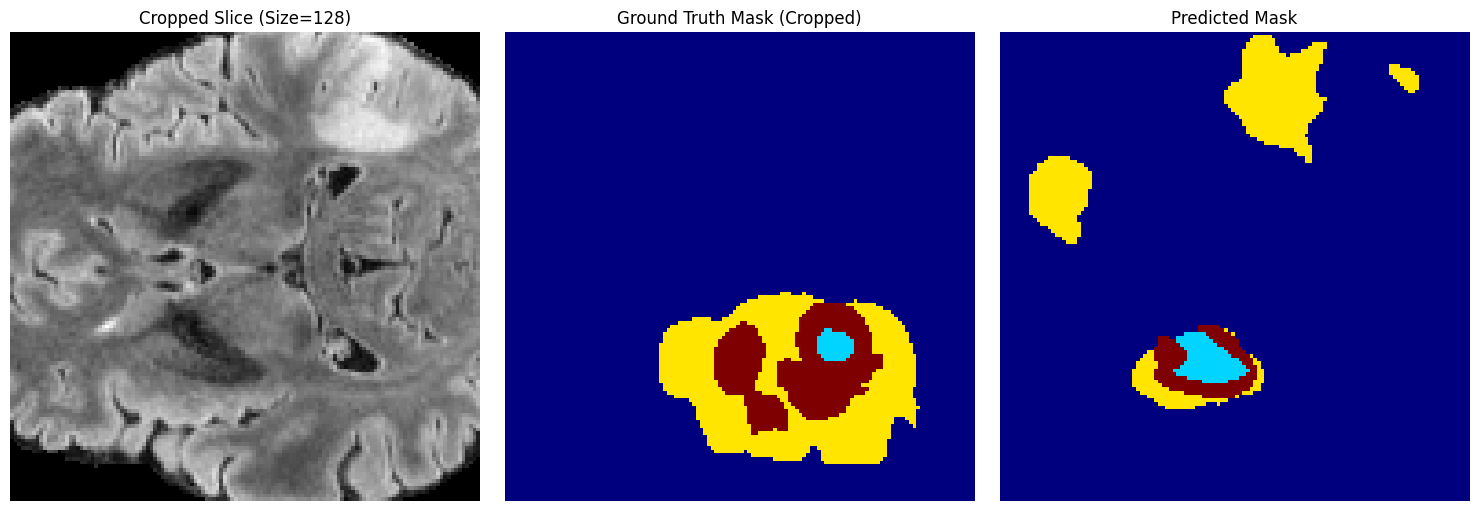

Hoàn thành dự đoán và hiển thị visualization.


In [34]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

# --- THÔNG SỐ CẤU HÌNH ---
# Điều chỉnh nếu mô hình của bạn có số lớp khác
NUM_CLASSES = 4
PATCH_SIZE = 128
SLICE_AXIS = 2 # Trục Z (D)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- KHAI BÁO MODEL (CẦN THAY THẾ BẰNG MODEL ĐÃ HUẤN LUYỆN CỦA BẠN) ---
# TẢI TRỌNG SỐ (Nếu có)
# model = CNN3DModel(input_channels=1, num_classes=NUM_CLASSES).to(DEVICE)
# Ví dụ: model.load_state_dict(torch.load('best_model.pth')) 
# Nếu không có file pth, mô hình sẽ dự đoán ngẫu nhiên.
model.eval() # Bắt buộc phải chuyển sang chế độ đánh giá

# ============================
# 1. Load ảnh NIfTI gốc (FLAIR)
# ============================
def load_nii(path):
    return nib.load(path).get_fdata()

# Sử dụng một kênh, ví dụ FLAIR
nii_path = "/dungnq/BraTS2021_Training_Data/BraTS2021_00008/BraTS2021_00008_flair.nii.gz"
full_img = load_nii(nii_path) 
# Chuyển từ (H, W, D) sang (D, H, W) cho dễ crop 3D
# Tuy nhiên, BraTS thường là (240, 240, 155), giữ nguyên thứ tự (H, W, D)

# ============================
# 2. Xử lý 3D Volume (Crop, Chuẩn hóa, Tensor)
# ============================

def center_crop_3d(img_3d, new_size=128):
    """ Crop 3D volume trung tâm """
    h, w, d = img_3d.shape
    
    # Hàng (Row)
    start_h = h//2 - new_size//2
    end_h   = start_h + new_size
    # Cột (Col)
    start_w = w//2 - new_size//2
    end_w   = start_w + new_size
    # Sâu (Depth)
    start_d = d//2 - new_size//2
    end_d   = start_d + new_size
    
    return img_3d[start_h:end_h, start_w:end_w, start_d:end_d]

# a. Crop 3D
cropped_volume_np = center_crop_3d(full_img, PATCH_SIZE)

# b. Chuẩn hóa (Sử dụng cách đã dùng trong dataset)
# (image - image.mean()) / (image.std() + 1e-6)
cropped_volume_norm = (cropped_volume_np - cropped_volume_np.mean()) / (cropped_volume_np.std() + 1e-6)

# c. Tạo Input Tensor
# Cần format PyTorch: [B, C, D, H, W]
# Input hiện tại: (D, H, W) nếu đã crop theo D, H, W.
# Nếu giữ nguyên (H, W, D) sau crop: [H, W, D] -> Permute [D, H, W] -> Add Channel [C, D, H, W] -> Add Batch [B, C, D, H, W]

# Giả định thứ tự của bạn là (H, W, D) như file gốc
input_tensor_volume = torch.tensor(cropped_volume_norm, dtype=torch.float32) 
# Permute (H, W, D) -> (D, H, W) 
input_tensor_volume = input_tensor_volume.permute(2, 0, 1) # [D, H, W]
# Add Channel (1) và Batch (1): [1, 1, D, H, W]
input_tensor = input_tensor_volume.unsqueeze(0).unsqueeze(0).to(DEVICE)


# ============================
# 3. Predict từ model
# ============================
print(f"Bắt đầu dự đoán với input shape: {input_tensor.shape}")

with torch.no_grad():
    # pred_tensor là output model dạng logits: (1, C, D, H, W)
    pred_tensor = model(input_tensor) 

# Chuyển logits thành mask dự đoán (chỉ mục lớp có xác suất cao nhất)
# torch.argmax trên dim=1 (Channel/Class)
# .cpu().numpy()[0]: Chuyển về numpy và loại bỏ Batch dimension
pred_mask_full = torch.argmax(pred_tensor, dim=1).cpu().numpy()[0]
# pred_mask_full shape là (D, H, W)


# ============================
# 4. Load mask ground truth & Chọn Slice
# ============================
mask_path = "/dungnq/BraTS2021_Training_Data/BraTS2021_00018/BraTS2021_00018_seg.nii.gz"
mask = load_nii(mask_path)

# Crop mask ground truth 3D
cropped_mask = center_crop_3d(mask, PATCH_SIZE)

# Lấy slice ở giữa của **VOLUME ĐÃ CROP**
slice_idx = PATCH_SIZE // 2 

# Ảnh gốc
full_slice = cropped_volume_np[:, :, slice_idx] # (H, W)
# Mask Ground Truth
mask_slice = cropped_mask[:, :, slice_idx]     # (H, W)
# Mask Dự đoán (pred_mask_full đang là D, H, W. Lấy slice theo D)
pred_slice = pred_mask_full[slice_idx, :, :]   # (H, W)


# ============================
# 5. Visualization 3 ảnh (Ảnh đã Crop, GT Mask, Pred Mask)
# ============================
# Lưu ý: Vì ta đang dự đoán trên PATCH 128x128x128, ta chỉ visualize các slice từ PATCH này.
# (Bạn đã loại bỏ Full NIfTI Slice và Cropped Slice trung tâm 2D vì chúng giống nhau sau bước 4)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title(f"Cropped Slice (Size={PATCH_SIZE})")
plt.imshow(full_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask (Cropped)")
plt.imshow(mask_slice, cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_slice, cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Hoàn thành dự đoán và hiển thị visualization.")

# Fusion

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphaBetaFusion(nn.Module):
    def __init__(self, model_cnn, model_unet, init_val=0.5, freeze_backbones=True):
        """
        Args:
            model_cnn: Mô hình 3D CNN đã định nghĩa
            model_unet: Mô hình 3D U-Net đã định nghĩa
            init_val: Giá trị khởi tạo cho alpha và beta (thường là 0.5)
            freeze_backbones: Có đóng băng trọng số của 2 model con hay không
        """
        super(AlphaBetaFusion, self).__init__()
        
        self.model_cnn = model_cnn
        self.model_unet = model_unet
        
        # --- ĐỊNH NGHĨA ALPHA VÀ BETA ---
        # nn.Parameter biến tensor thường thành tham số có thể train (có gradient)
        # requires_grad=True mặc định
        self.alpha = nn.Parameter(torch.tensor(init_val))
        self.beta = nn.Parameter(torch.tensor(init_val))
        
        # Tùy chọn: Đóng băng 2 model gốc để chỉ train alpha và beta (nhanh hơn)
        if freeze_backbones:
            for param in self.model_cnn.parameters():
                param.requires_grad = False
            for param in self.model_unet.parameters():
                param.requires_grad = False

    def forward(self, x):
        # 1. Forward qua từng model để lấy logits
        logits_cnn = self.model_cnn(x)
        logits_unet = self.model_unet(x)
        
        # 2. Xử lý chênh lệch kích thước (QUAN TRỌNG)
        # Theo tài liệu[cite: 75, 76], U-Net gốc thường có output nhỏ hơn input
        # do không dùng padding. Ta cần resize logits_unet về bằng logits_cnn.
        if logits_cnn.shape != logits_unet.shape:
            logits_unet = F.interpolate(
                logits_unet, 
                size=logits_cnn.shape[2:], # Lấy (D, H, W) của CNN làm chuẩn
                mode='trilinear', 
                align_corners=False
            )
            
        # 3. Nhân hệ số và cộng gộp (Fusion)
        # Công thức: Final = alpha * CNN + beta * UNet
        fused_logits = (self.alpha * logits_cnn) + (self.beta * logits_unet)
        
        return fused_logits

# --- Cách sử dụng ---
# model = AlphaBetaFusion(your_cnn, your_unet)
# print(f"Alpha ban đầu: {model.alpha.item()}, Beta ban đầu: {model.beta.item()}")

# Sau khi train xong, bạn có thể xem mô hình tin tưởng mạng nào hơn:
# print(f"Alpha sau train: {model.alpha.item()}, Beta sau train: {model.beta.item()}")

In [8]:
unet = UNet3D(n_channels=1, n_classes=4).cuda()
cnn = CNN3DModel(input_channels=1, num_classes=4).cuda()
unet.load_state_dict(torch.load("/dungnq/best_unet3d_brats.pth", weights_only=True))
cnn.load_state_dict(torch.load("/dungnq/best_3dcnn_brats.pth", weights_only=True))
model = AlphaBetaFusion(unet, cnn)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [46]:
for epoch in range(5):
    model.train()
    losses = []
    for img, mask in tqdm(train_loader):
        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)
        loss = combined_loss(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch + 1}: Loss = {sum(losses)/len(losses):.4f}")
    if epoch%3 == 1:
        model.eval()
        val_losses = []
        val_dices = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/20 [Valid]")
            for img, mask in val_pbar:
                img = img.cuda()
                mask = mask.cuda()

                pred = model(img)
                
                # 1. Tính Loss
                loss = combined_loss(pred, mask)
                val_losses.append(loss.item())
                
                # 2. Tính Dice Score (Metric đánh giá thực tế)
                dice = calculate_dice(pred, mask, num_classes=4)
                val_dices.append(dice)
                
                val_pbar.set_postfix({'val_loss': loss.item(), 'dice': dice})

        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_dice = sum(val_dices) / len(val_dices)

        # ================= LOGGING & SAVE =================
        print(f"\nEND EPOCH {epoch+1}:")
        # print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Valid Loss: {avg_val_loss:.4f} | Valid Dice: {avg_val_dice:.4f}")

        # Chỉ lưu model nếu Dice score cải thiện
        if avg_val_dice > best_dice:
            print(f"  >>> Model Improved (Dice: {best_dice:.4f} -> {avg_val_dice:.4f}). Saving...")                                                                                                          
            torch.save(model.state_dict(), "best_fusion_brats.pth")
            best_dice = avg_val_dice
        
        print("-" * 50)

100%|██████████| 63/63 [00:53<00:00,  1.17it/s]


Epoch 1: Loss = 0.3843


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 2: Loss = 0.3820


Epoch 2/20 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, val_loss=0.443, dice=0.461]



END EPOCH 2:
  Valid Loss: 0.4223 | Valid Dice: 0.4903
  >>> Model Improved (Dice: 0.0000 -> 0.4903). Saving...
--------------------------------------------------


100%|██████████| 63/63 [00:53<00:00,  1.17it/s]


Epoch 3: Loss = 0.3822


100%|██████████| 63/63 [00:53<00:00,  1.17it/s]


Epoch 4: Loss = 0.3808


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 5: Loss = 0.3809


Epoch 5/20 [Valid]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, val_loss=0.396, dice=0.523]



END EPOCH 5:
  Valid Loss: 0.4021 | Valid Dice: 0.5177
  >>> Model Improved (Dice: 0.4903 -> 0.5177). Saving...
--------------------------------------------------


Bắt đầu dự đoán với input shape: torch.Size([1, 1, 128, 128, 128])


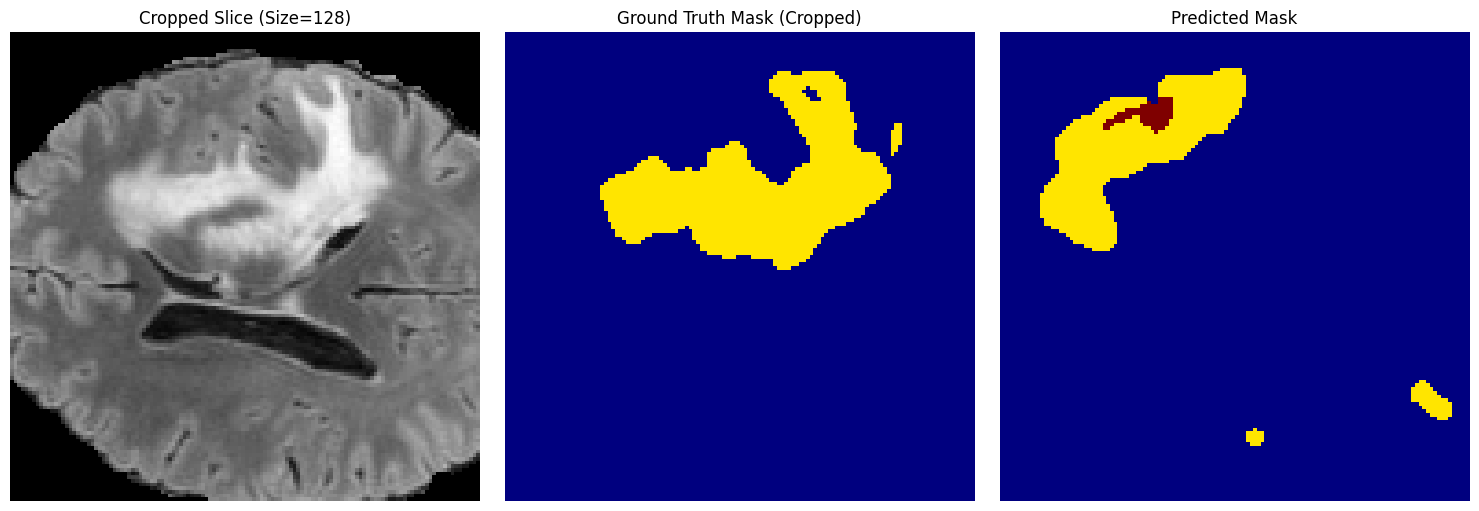

Hoàn thành dự đoán và hiển thị visualization.


In [44]:
def visualize(indx):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    import os

    # --- THÔNG SỐ CẤU HÌNH ---
    # Điều chỉnh nếu mô hình của bạn có số lớp khác
    NUM_CLASSES = 4
    PATCH_SIZE = 128
    SLICE_AXIS = 2 # Trục Z (D)
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                                                                                                                  #;model = unet                                                                                                                                                                            

    # --- KHAI BÁO MODEL (CẦN THAY THẾ BẰNG MODEL ĐÃ HUẤN LUYỆN CỦA BẠN) ---
    # TẢI TRỌNG SỐ (Nếu có)
    # model = CNN3DModel(input_channels=1, num_classes=NUM_CLASSES).to(DEVICE)
    # Ví dụ: model.load_state_dict(torch.load('best_model.pth')) 
    # Nếu không có file pth, mô hình sẽ dự đoán ngẫu nhiên.
    model.eval() # Bắt buộc phải chuyển sang chế độ đánh giá

    # ============================
    # 1. Load ảnh NIfTI gốc (FLAIR)
    # ============================
    def load_nii(path):
        return nib.load(path).get_fdata()

    # Sử dụng một kênh, ví dụ FLAIR
    nii_path = f"/dungnq/BraTS2021_test_Data/BraTS2021_000{indx}/BraTS2021_000{indx}_flair.nii.gz"
    if indx > 1000:
        nii_path = f"/dungnq/BraTS2021_test_Data/BraTS2021_0{indx}/BraTS2021_0{indx}_flair.nii.gz"
    full_img = load_nii(nii_path) 
    # Chuyển từ (H, W, D) sang (D, H, W) cho dễ crop 3D
    # Tuy nhiên, BraTS thường là (240, 240, 155), giữ nguyên thứ tự (H, W, D)

    # ============================
    # 2. Xử lý 3D Volume (Crop, Chuẩn hóa, Tensor)
    # ============================

    def center_crop_3d(img_3d, new_size=128):
        """ Crop 3D volume trung tâm """
        h, w, d = img_3d.shape
        
        # Hàng (Row)
        start_h = h//2 - new_size//2
        end_h   = start_h + new_size
        # Cột (Col)
        start_w = w//2 - new_size//2
        end_w   = start_w + new_size
        # Sâu (Depth)
        start_d = d//2 - new_size//2
        end_d   = start_d + new_size
        
        return img_3d[start_h:end_h, start_w:end_w, start_d:end_d]

    # a. Crop 3D
    cropped_volume_np = center_crop_3d(full_img, PATCH_SIZE)

    # b. Chuẩn hóa (Sử dụng cách đã dùng trong dataset)
    # (image - image.mean()) / (image.std() + 1e-6)
    cropped_volume_norm = (cropped_volume_np - cropped_volume_np.mean()) / (cropped_volume_np.std() + 1e-6)

    # c. Tạo Input Tensor
    # Cần format PyTorch: [B, C, D, H, W]
    # Input hiện tại: (D, H, W) nếu đã crop theo D, H, W.
    # Nếu giữ nguyên (H, W, D) sau crop: [H, W, D] -> Permute [D, H, W] -> Add Channel [C, D, H, W] -> Add Batch [B, C, D, H, W]

    # Giả định thứ tự của bạn là (H, W, D) như file gốc
    input_tensor_volume = torch.tensor(cropped_volume_norm, dtype=torch.float32) 
    # Permute (H, W, D) -> (D, H, W) 
    input_tensor_volume = input_tensor_volume.permute(2, 0, 1) # [D, H, W]
    # Add Channel (1) và Batch (1): [1, 1, D, H, W]
    input_tensor = input_tensor_volume.unsqueeze(0).unsqueeze(0).to(DEVICE)


    # ============================
    # 3. Predict từ model
    # ============================
    print(f"Bắt đầu dự đoán với input shape: {input_tensor.shape}")                                                                                                               
                                                            
    with torch.no_grad():
        # pred_tensor là output model dạng logits: (1, C, D, H, W)
        pred_tensor = model(input_tensor) 

    # Chuyển logits thành mask dự đoán (chỉ mục lớp có xác suất cao nhất)
    # torch.argmax trên dim=1 (Channel/Class)
    # .cpu().numpy()[0]: Chuyển về numpy và loại bỏ Batch dimension
    pred_mask_full = torch.argmax(pred_tensor, dim=1).cpu().numpy()[0]
    # pred_mask_full shape là (D, H, W)


    # ============================
    # 4. Load mask ground truth & Chọn Slice
    # ============================
    mask_path = f"/dungnq/BraTS2021_test_Data/BraTS2021_000{indx}/BraTS2021_000{indx}_seg.nii.gz"
    if indx > 1000:
        mask_path = f"/dungnq/BraTS2021_test_Data/BraTS2021_0{indx}/BraTS2021_0{indx}_seg.nii.gz"
    mask = load_nii(mask_path)

    # Crop mask ground truth 3D
    cropped_mask = center_crop_3d(mask, PATCH_SIZE)

    # Lấy slice ở giữa của **VOLUME ĐÃ CROP**
    slice_idx = PATCH_SIZE // 2 

    # Ảnh gốc
    full_slice = cropped_volume_np[:, :, slice_idx] # (H, W)
    # Mask Ground Truth
    mask_slice = cropped_mask[:, :, slice_idx]     # (H, W)
    # Mask Dự đoán (pred_mask_full đang là D, H, W. Lấy slice theo D)
    pred_slice = pred_mask_full[slice_idx, :, :]   # (H, W)


    # ============================
    # 5. Visualization 3 ảnh (Ảnh đã Crop, GT Mask, Pred Mask)
    # ============================
    # Lưu ý: Vì ta đang dự đoán trên PATCH 128x128x128, ta chỉ visualize các slice từ PATCH này.
    # (Bạn đã loại bỏ Full NIfTI Slice và Cropped Slice trung tâm 2D vì chúng giống nhau sau bước 4)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Cropped Slice (Size={PATCH_SIZE})")
    plt.imshow(full_slice, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask (Cropped)")
    plt.imshow(mask_slice, cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_slice, cmap='jet', vmin=0, vmax=NUM_CLASSES - 1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Hoàn thành dự đoán và hiển thị visualization.")

Bắt đầu dự đoán với input shape: torch.Size([1, 1, 128, 128, 128])


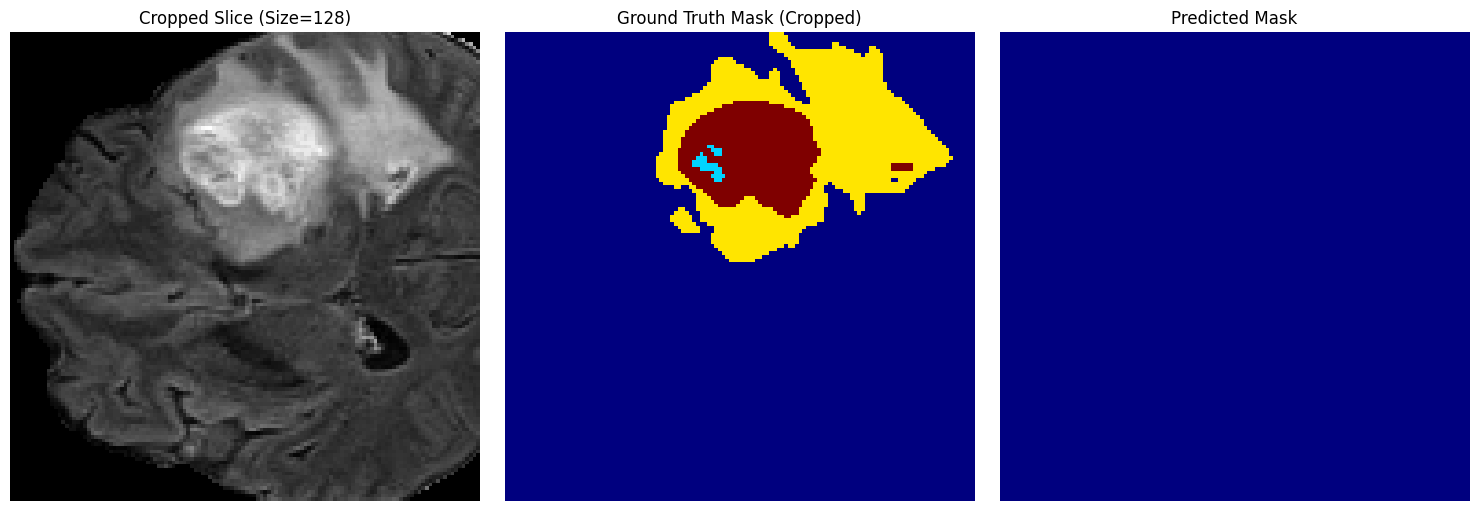

Hoàn thành dự đoán và hiển thị visualization.


In [107]:
visualize(1362)